In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab \Notebooks/microscopy_self_supervised_learning/

/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning


Imports & setup

In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from skimage.io import imread
from skimage.transform import resize
import cv2

Paths & metadata

In [5]:
metadata = pd.read_csv("data/processed/metadata_with_moa.csv")
metadata.head(3)

,Unnamed: 0,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,plate,well,Replicate,compound,concentration,moa
0,0,1,11,Week1_150607_B04_s3_w135D66B4C-0548-4AB8-A57B-...,Week1/Week1_22123,Week1_150607_B04_s3_w2D81AEFB9-9DD4-4B59-9177-...,Week1/Week1_22123,Week1_150607_B04_s3_w408BE006A-BF34-457E-81A9-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors
1,1,1,12,Week1_150607_B04_s4_w1EB720AD1-83BA-48A7-8C47-...,Week1/Week1_22123,Week1_150607_B04_s4_w261B79A05-7534-46F3-8C80-...,Week1/Week1_22123,Week1_150607_B04_s4_w49FF7E7B1-F049-4994-BCA2-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors
2,2,1,9,Week1_150607_B04_s1_w11323931B-BDA7-4F42-870E-...,Week1/Week1_22123,Week1_150607_B04_s1_w2F8F7EA7A-EC57-49CA-A556-...,Week1/Week1_22123,Week1_150607_B04_s1_w494DCA5C4-3531-497D-A8B0-...,Week1/Week1_22123,Week1_22123,B04,1,cytochalasin B,10.0,Actin disruptors


In [6]:
DATA_DIR = "data/raw"
RESULTS_DIR = "results/figures"

In [79]:
metadata['Image_FileName_DAPI'][0]

'Week1_150607_B04_s3_w135D66B4C-0548-4AB8-A57B-9CC39666813B.tif'

Image loader function

In [117]:
import os
import tifffile as tiff
import numpy as np

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning/data/raw"

def fix_path(pathname):
    return pathname.split("/")[-1]

def load_3channel_image(row):
    paths = [
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_DAPI"]), row["Image_FileName_DAPI"]),
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_Tubulin"]), row["Image_FileName_Tubulin"]),
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_Actin"]), row["Image_FileName_Actin"])
    ]

    channels = []
    for p in paths:
        img = tiff.imread(path).astype(np.float32)
        # normalize
        img = img / 65535.0   # for uint16

        # resize
        img = cv2.resize(img, (128,128))
        channels.append(img)

    img_stack = np.stack(channels, axis=0)   # (3, H, W)
    return img_stack

Dataset class

In [118]:
from skimage.transform import resize
import torch

class MicroscopyDataset(Dataset):
    def __init__(self, metadata_df, img_size=128):
        self.meta = metadata_df.reset_index(drop=True)
        self.img_size = img_size

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        img = load_3channel_image(row)   # (3,1024,1280)

        # resize to (3,128,128)
        img = resize(img, (3, self.img_size, self.img_size), anti_aliasing=True)

        img = torch.tensor(img, dtype=torch.float32)
        label = row["moa"]
        return img, label

In [119]:
path = '/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning/data/raw/Week1_22123/Week1_150607_B04_s3_w135D66B4C-0548-4AB8-A57B-9CC39666813B.tif'
img = tiff.imread(path)

print(img.shape)
print(img.dtype)
print(img.min(), img.max())

(1024, 1280)
uint16
208 7488


DataLoader

In [120]:
n = min(2000, len(metadata))
subset = metadata.sample(n=n, random_state=42)

In [121]:
len(metadata)

300

In [122]:
subset = metadata.sample(n=min(50, len(metadata)), random_state=42)
dataset = MicroscopyDataset(subset)

dataset = MicroscopyDataset(subset, img_size=128)
x, y = dataset[0]
print(x.shape)

torch.Size([3, 128, 128])


In [123]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [124]:
batch = next(iter(dataloader))
print(batch[0].shape)

torch.Size([16, 3, 128, 128])


Autoencoder model

In [125]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*128*128, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 3*128*128),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(-1, 3, 128, 128)
        return out, z

Train setup

In [126]:
model = Autoencoder(latent_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

Training loop

In [127]:
x, y = dataset[0]
print(x.shape)   # must be torch.Size([3,128,128])

torch.Size([3, 128, 128])


In [128]:
batch = next(iter(dataloader))
print(batch[0].shape)  # torch.Size([B,3,128,128])

torch.Size([16, 3, 128, 128])


In [129]:
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for imgs, labels in loop:
        imgs = imgs.float().to(device)

        recon, embedding = model(imgs)   # unpack tuple

        loss = criterion(recon, imgs)    # only compare reconstruction

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader)
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

Epoch 1/10: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, loss=0.217]


Epoch 1 Loss: 0.2308


Epoch 2/10: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it, loss=0.0739]


Epoch 2 Loss: 0.1364


Epoch 3/10: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, loss=0.00258]


Epoch 3 Loss: 0.0163


Epoch 4/10: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it, loss=0.000227]


Epoch 4 Loss: 0.0005


Epoch 5/10: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it, loss=0.000222]


Epoch 5 Loss: 0.0002


Epoch 6/10: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it, loss=0.000222]


Epoch 6 Loss: 0.0002


Epoch 7/10: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, loss=0.000222]


Epoch 7 Loss: 0.0002


Epoch 8/10: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it, loss=0.000222]


Epoch 8 Loss: 0.0002


Epoch 9/10: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, loss=0.000222]


Epoch 9 Loss: 0.0002


Epoch 10/10: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it, loss=0.000222]

Epoch 10 Loss: 0.0002


Plot training loss

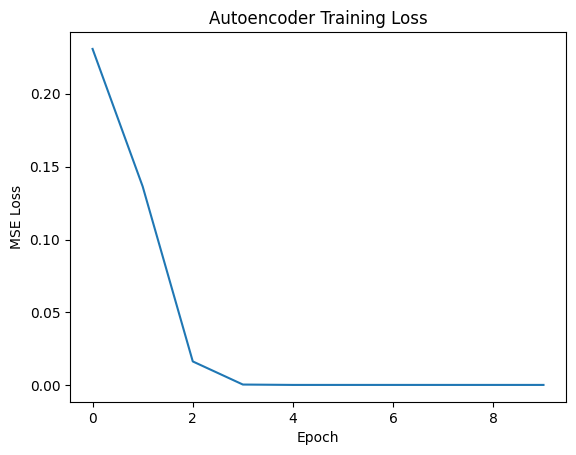

In [130]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.savefig(f"{RESULTS_DIR}/autoencoder_loss.png")
plt.show()

Reconstruction visualization

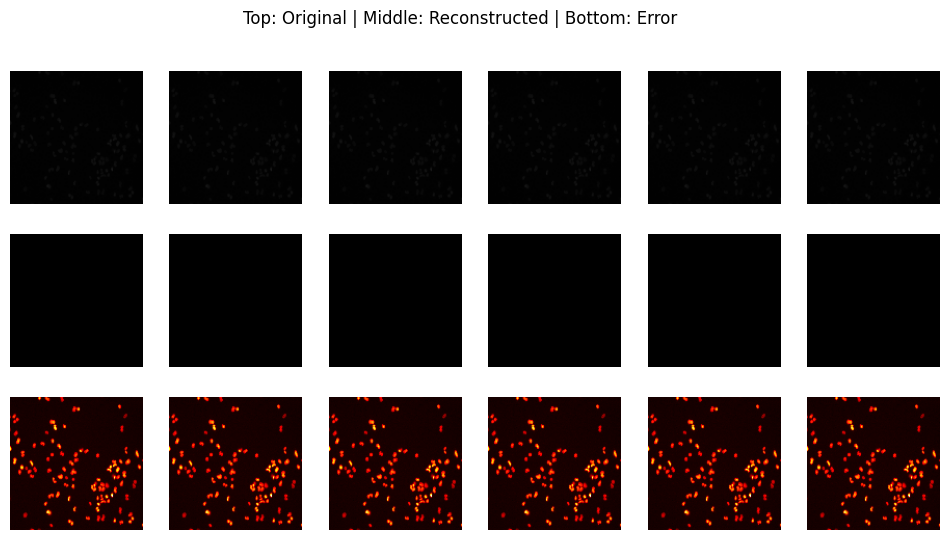

In [131]:
model.eval()
imgs, labels = next(iter(dataloader))
imgs = imgs.to(device)

with torch.no_grad():
    recon, z = model(imgs)

imgs = imgs.cpu().numpy()
recon = recon.cpu().numpy()

fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for i in range(6):
    orig = imgs[i,0]
    rec  = recon[i,0]
    err  = np.abs(orig - rec)

    axes[0,i].imshow(orig, cmap="gray", vmin=0, vmax=1)
    axes[1,i].imshow(rec,  cmap="gray", vmin=0, vmax=1)
    axes[2,i].imshow(err,  cmap="hot")

    for j in range(3):
        axes[j,i].axis("off")

plt.suptitle("Top: Original | Middle: Reconstructed | Bottom: Error")
plt.savefig(f"{RESULTS_DIR}/autoencoder_reconstructions.png")
plt.show()

fixed : normalisation

Middle row (reconstruction):
❌ Looks like random noise / static
❌ No cell structure recovered
❌ Almost constant texture across images

→ confirms the model is not reconstructing meaningful signal.

Extract embeddings

In [113]:
embeddings = []
labels = []

model.eval()

for _, row in tqdm(subset.iterrows(), total=len(subset)):

    img = load_3channel_image(row)  # (3,1024,1280)

    img_small = resize(img, (3,128,128), anti_aliasing=True)

    x = torch.tensor(img_small, dtype=torch.float32)
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        recon, z = model(x)

    embeddings.append(z.cpu().numpy().squeeze())
    labels.append(row["moa"])

100%|██████████| 50/50 [00:04<00:00, 10.26it/s]


Save embeddings

In [114]:
embeddings = np.array(embeddings)

np.save("data/processed/autoencoder_embeddings.npy", embeddings)
subset[["moa"]].to_csv("data/processed/autoencoder_labels.csv", index=False)

print("Saved embeddings:", embeddings.shape)

Saved embeddings: (50, 128)


UMAP visualization

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


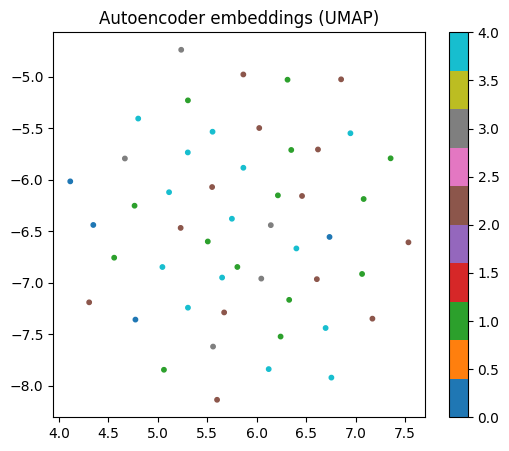

In [115]:
from umap import UMAP
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(labels)

umap = UMAP(n_components=2, random_state=42)
Z = umap.fit_transform(embeddings)

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=y_enc, cmap="tab10", s=10)
plt.title("Autoencoder embeddings (UMAP)")
plt.colorbar()
plt.savefig(f"{RESULTS_DIR}/umap_autoencoder_by_moa.png")
plt.show()